# Проект: "Предсказание температуры стали"

## Часть 1: Информация о проекте

**Заказчик:** ООО «Так закаляем сталь» 

**Бизнес-задача:** уменьшить потребление электроэнергии --> оптимизировать производственные расходы

**Данные:** 7 датасетов

**Обозначения датасетов:**

    - data_arc_new.csv — данные об электродах;

    - data_bulk_new.csv — данные о подаче сыпучих материалов (объём);

    - data_bulk_time_new.csv — данные о подаче сыпучих материалов (время);

    - data_gas_new.csv — данные о продувке сплава газом;

    - data_temp_new.csv — результаты измерения температуры;

    - data_wire_new.csv — данные о проволочных материалах (объём);

    - data_wire_time_new.csv — данные о проволочных материалах (время).
    
**Задача DS:** предсказать температуру стали в зависимости от различных данных

## Часть 2: Работа с данными

Импортируем библиотеки

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sb

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error,make_scorer,mean_absolute_error
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import GridSearchCV, train_test_split, cross_val_score
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from sklearn.dummy import DummyRegressor
from lightgbm import plot_importance

In [2]:
RANDOM_STATE = 170723
CV=5

In [3]:
def model_initialize(model, params):
    model_ = GridSearchCV(model, params, cv=CV, scoring=mae)
    model_.fit(train_features, train_target)
    score = abs(model_.best_score_)               
    print(f'\nMAE of {model.__class__.__name__} = {score}')
    return model_.best_estimator_, score

Загрузим данные

In [4]:
data_arc_new=pd.read_csv('/datasets/data_arc_new.csv')

data_bulk_new=pd.read_csv('/datasets/data_bulk_new.csv')

data_bulk_time_new=pd.read_csv('/datasets/data_bulk_time_new.csv')

data_gas_new=pd.read_csv('/datasets/data_gas_new.csv')

data_temp_new=pd.read_csv('/datasets/data_temp_new.csv')

data_wire_new=pd.read_csv('/datasets/data_wire_new.csv')

data_wire_time_new=pd.read_csv('/datasets/data_wire_time_new.csv')

all_data=[data_arc_new,data_bulk_new,data_bulk_time_new,data_gas_new,data_temp_new,data_wire_new,data_wire_time_new]

In [5]:
for i in all_data:
    print(i.shape)

(14876, 5)
(3129, 16)
(3129, 16)
(3239, 2)
(18092, 3)
(3081, 10)
(3081, 10)


Больше всего строк в файле "data_temp_new"

Больше всего столбцов в файлах "data_bulk_new" и "data_bulk_time_new"

In [6]:
for i in all_data:
    print(i.info(), '\n'*2,i.head(),'\n','_ '*40)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14876 entries, 0 to 14875
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   key                   14876 non-null  int64  
 1   Начало нагрева дугой  14876 non-null  object 
 2   Конец нагрева дугой   14876 non-null  object 
 3   Активная мощность     14876 non-null  float64
 4   Реактивная мощность   14876 non-null  float64
dtypes: float64(2), int64(1), object(2)
memory usage: 581.2+ KB
None 

    key Начало нагрева дугой  Конец нагрева дугой  Активная мощность  \
0    1  2019-05-03 11:02:14  2019-05-03 11:06:02           0.305130   
1    1  2019-05-03 11:07:28  2019-05-03 11:10:33           0.765658   
2    1  2019-05-03 11:11:44  2019-05-03 11:14:36           0.580313   
3    1  2019-05-03 11:18:14  2019-05-03 11:24:19           0.518496   
4    1  2019-05-03 11:26:09  2019-05-03 11:28:37           0.867133   

   Реактивная мощность  
0          

К исправлению:

    - дата является строкой (решение - станет датой)
    - очень много пропусков в bulk и wire файлах (решение - более детально изучить пропуски, превратить их в 0)

Изучим числовые данные:

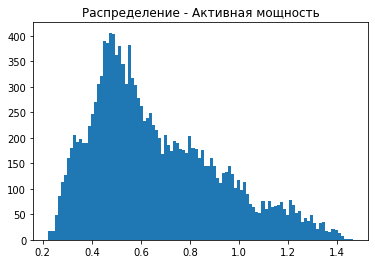

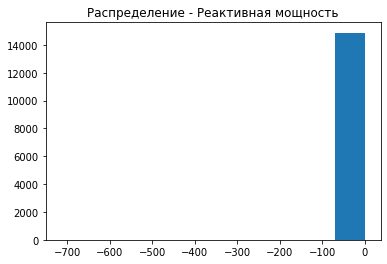

In [7]:
plt.hist(data_arc_new['Активная мощность'],bins=100)
plt.title('Распределение - Активная мощность')
plt.show()

plt.hist(data_arc_new['Реактивная мощность'])
plt.title('Распределение - Реактивная мощность')
plt.show()


Определенно обнаружен **выброс** в "Реактивная мощность"

In [8]:
data_arc_new[data_arc_new['Реактивная мощность']==data_arc_new['Реактивная мощность'].min()].index

Int64Index([9780], dtype='int64')

In [9]:
data_arc_new.drop(index=data_arc_new[data_arc_new['Реактивная мощность']==data_arc_new['Реактивная мощность'].min()].index,inplace=True)

In [10]:
data_arc_new[data_arc_new['Реактивная мощность']==data_arc_new['Реактивная мощность'].min()]

,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность
709,152,2019-05-09 11:26:58,2019-05-09 11:29:41,0.228852,0.153777


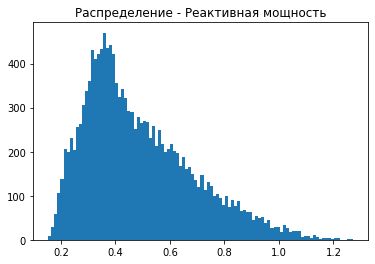

In [11]:
plt.hist(data_arc_new['Реактивная мощность'],bins=100)
plt.title('Распределение - Реактивная мощность')
plt.show()

Распределение у активной и реактивной мощностей схожие, напоминают нормальное (скорее даже Хи-2)

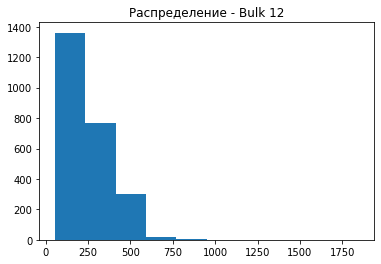

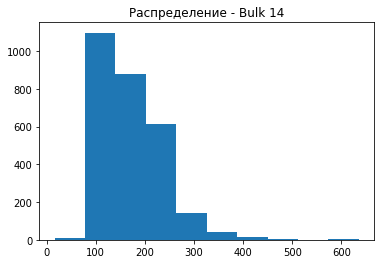

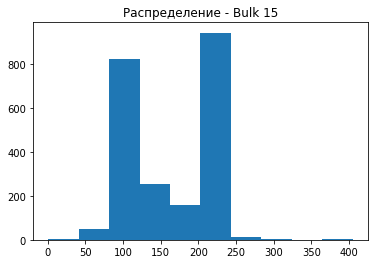

In [12]:

plt.hist(data_bulk_new['Bulk 12'])
plt.title('Распределение - Bulk 12')
plt.show()

plt.hist(data_bulk_new['Bulk 14'])
plt.title('Распределение - Bulk 14')
plt.show()




plt.hist(data_bulk_new['Bulk 15'])
plt.title('Распределение - Bulk 15')
plt.show()

# PS 12, 14 и 15 были выбраны, потому что в них больше всего данных

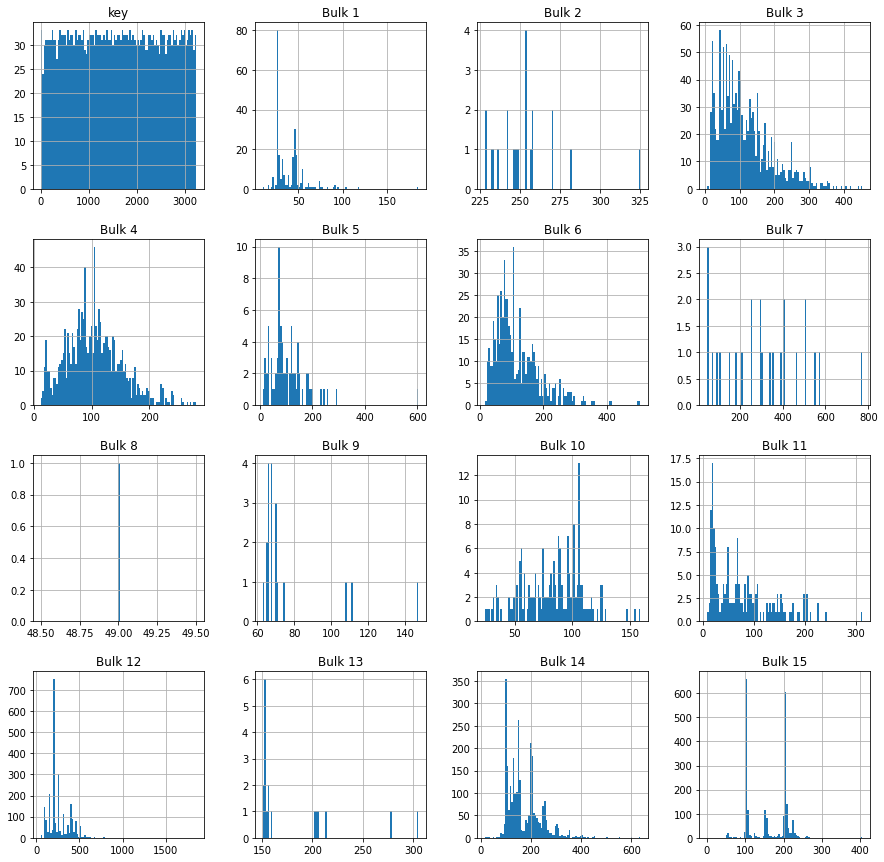

In [13]:

data_bulk_new.hist(figsize=(15, 15), bins=100)
plt.show()

Распределения Bulk мало похожи друг на друга

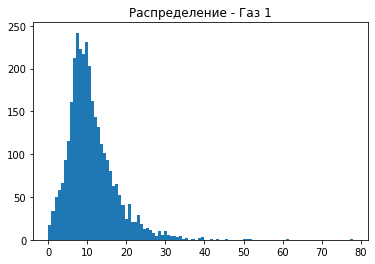

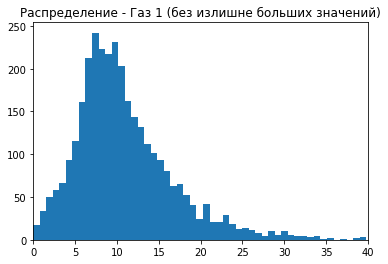

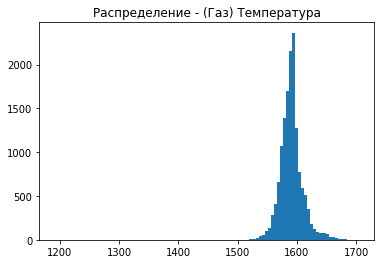

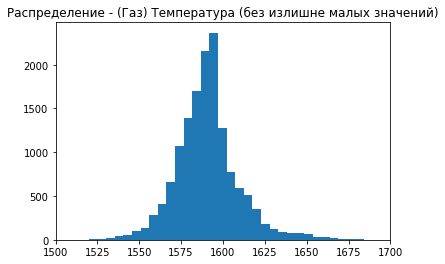

In [14]:


plt.hist(data_gas_new['Газ 1'],bins=100)
plt.title('Распределение - Газ 1')
plt.show()

plt.hist(data_gas_new['Газ 1'],bins=100)
plt.xlim(0,40)
plt.title('Распределение - Газ 1 (без излишне больших значений)')
plt.show()

plt.hist(data_temp_new['Температура'],bins=100)
plt.title('Распределение - (Газ) Температура')
plt.show()

plt.hist(data_temp_new['Температура'],bins=100)
plt.xlim(1500,1700)

plt.title('Распределение - (Газ) Температура (без излишне малых значений)')
plt.show()

Сразу же избавимся от значений менее 1400, поскольку технология не предусматривает подобные случаи

In [15]:
data_temp_new=data_temp_new.drop(data_temp_new[data_temp_new['Температура']<1400].index,axis=0)

In [16]:
data_temp_new

,key,Время замера,Температура
0,1,2019-05-03 11:02:04,1571.0
1,1,2019-05-03 11:07:18,1604.0
2,1,2019-05-03 11:11:34,1618.0
3,1,2019-05-03 11:18:04,1601.0
4,1,2019-05-03 11:25:59,1606.0
...,...,...,...
18087,3241,2019-09-06 16:55:01,NaN
18088,3241,2019-09-06 17:06:38,NaN
18089,3241,2019-09-06 17:21:48,NaN
18090,3241,2019-09-06 17:24:44,NaN


Распределения по столбцам "Газ 1" и "Температура" схожи, напоминают нормальное распределение. Есть выброс, который успешно устранен.

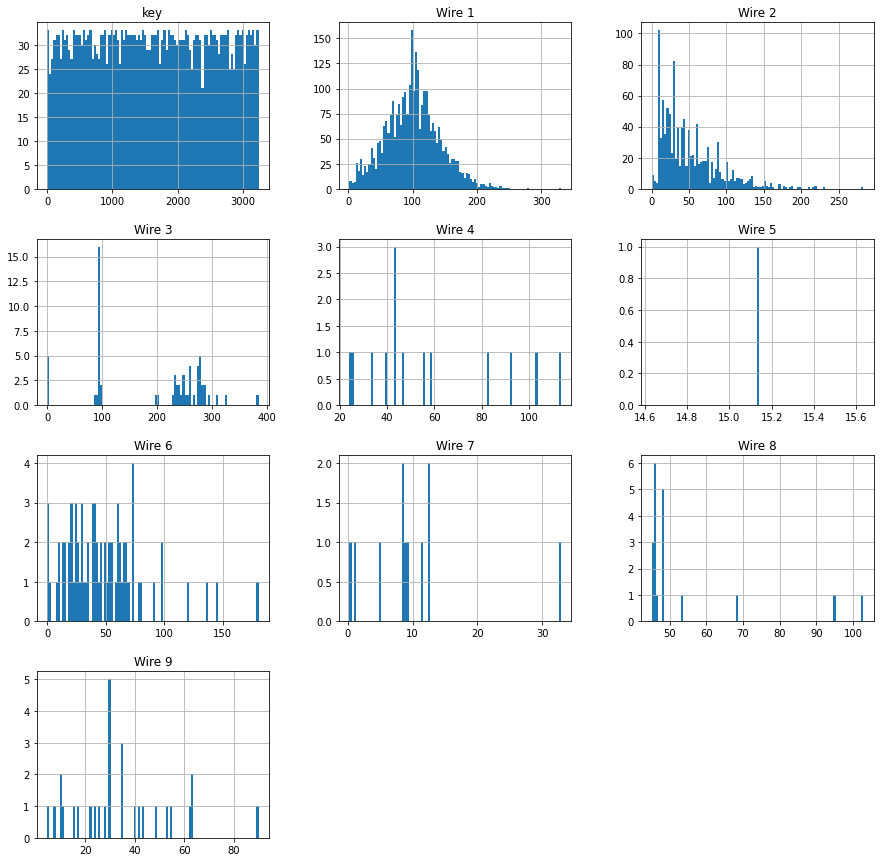

In [17]:



data_wire_new.hist(figsize=(15, 15), bins=100)
plt.show()


Распределение по столбцу "Wire 1" напоминает нормальное

Распределение по столбцу "Wire 2" напоминает экспоненциальное


___

Сделаем дату датой

In [18]:
wires=list()
for i in range(1,10):
    wires.append(f'Wire {i}')

bulks=list()
for i in range(1,16):
    bulks.append(f'Bulk {i}')


    
    

In [19]:
data_arc_new['Начало нагрева дугой']=pd.to_datetime(data_arc_new['Начало нагрева дугой'],errors='coerce')
data_arc_new['Конец нагрева дугой']=pd.to_datetime(data_arc_new['Конец нагрева дугой'],errors='coerce')

data_bulk_time_new[bulks]=pd.to_datetime(data_bulk_time_new[bulks].stack(),errors='coerce').unstack()

data_temp_new['Время замера']=pd.to_datetime(data_temp_new['Время замера'],errors='coerce')

data_wire_time_new[wires]=pd.to_datetime(data_wire_time_new[wires].stack(),errors='coerce').unstack()

In [20]:
data_wire_time_new.head()
# работает!

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,2019-05-03 11:06:19,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT
1,2,2019-05-03 11:36:50,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT
2,3,2019-05-03 12:11:46,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT
3,4,2019-05-03 12:43:22,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT
4,5,2019-05-03 13:20:44,2019-05-03 13:15:34,NaT,NaT,NaT,NaT,NaT,NaT,NaT


## Часть 3: План действий

**1. Предобработка исходных данных.** Изучение данных, избавление от выбросов и дубликатов.

**2. Подготовка данных к обучению.** Вычленение нужных для обучения данных, изучение корелляции между данными,

**3. Подбор релевантной модели и её обучение.** Проверка эффективности различных моделей с различными гиперпараметрами.

**4. Тестирование модели.** Тестирование на отдельном наборе данных, проверка модели на адекватность.

#### Выводы: ####

- данные считаны
- в некоторых данных имеются аномальные значения - они могут быть впоследствии удалены
- исправлен формат даты
- в некоторых данных имеются пропуски - предложены варианты их устранения

## Часть 4: Вопросы

- Как следует интерпретировать столбцы "Активная мощность" и "Реактивная мощность", в чем отличия?

- "Начало нагрева дугой" и	"Конец нагрева дугой" даны для нахождения времени нагрева?

- Почему в существуют 15 столбцов Bulk и 9 Wire? Что означают эти столбцы?

- Были ли в технологии производства какие-либо изменения с течением времени?

- Как именно прогноз температуры повлияет на повышении эффективности?

## Часть 5: Очистка данных

Если в данных о температуре есть пропуски, значит эти данные нельзя использовать. Удалим пропуски

In [21]:
data_temp_new.dropna(axis=0,subset=['Температура'],inplace=True)

Эмпирическим путём выяснено, что после удаления остались одиночные строки (один ключ = одна строка), которые могут исказить результат. Удалим подобные строки.

In [22]:
def destroy_singles(data):
    temp = data['key'].value_counts()
    len_data_start = len(data)
    data_new = data[data.key.isin (temp[temp.values > 1].index)]
    print('Deleted:', len_data_start - len(data_new))
    
    return data_new
data_temp_new = destroy_singles(data_temp_new)

Deleted: 740


Как было сказано в Части 2, заменим нулями NaN в данных о Wire и Bulk

In [23]:
data_bulk_new.fillna(0,inplace=True)
data_wire_new.fillna(0,inplace=True)
data_bulk_new.head() # проверка

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,0.0,0.0,0.0,43.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,206.0,0.0,150.0,154.0
1,2,0.0,0.0,0.0,73.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,206.0,0.0,149.0,154.0
2,3,0.0,0.0,0.0,34.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,205.0,0.0,152.0,153.0
3,4,0.0,0.0,0.0,81.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,207.0,0.0,153.0,154.0
4,5,0.0,0.0,0.0,78.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,203.0,0.0,151.0,152.0


По формуле ниже объединим Активную и Реактивную мощности в Полную мощность

$$
E_{по}=\sqrt{E_{реак}^2 + E_{акт}^2}
$$


In [24]:
data_arc_new['full_energy']=(data_arc_new['Активная мощность']**(2)+data_arc_new['Реактивная мощность']**(2))**0.5

In [25]:
data_arc_new.head()

,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность,full_energy
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.305130,0.211253,0.371123
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.765658,0.477438,0.902319
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.580313,0.430460,0.722536
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,0.518496,0.379979,0.642824
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.867133,0.643691,1.079934


Посмотрим, сколько секунд ушло на каждую строку, укажем это в новом столбце

In [26]:
data_arc_new['line_time']= (data_arc_new['Конец нагрева дугой'] - data_arc_new['Начало нагрева дугой']).dt.total_seconds()
data_arc_new.head()

,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность,full_energy,line_time
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.305130,0.211253,0.371123,228.0
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.765658,0.477438,0.902319,185.0
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.580313,0.430460,0.722536,172.0
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,0.518496,0.379979,0.642824,365.0
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.867133,0.643691,1.079934,148.0


Заглядывая вперед, посмотрим на агрегированные данные

In [27]:
data_arc_new.groupby('key')['line_time'].sum()

key
1       1098.0
2        811.0
3        655.0
4        741.0
5        869.0
         ...  
3237     909.0
3238     546.0
3239    1216.0
3240     839.0
3241     659.0
Name: line_time, Length: 3214, dtype: float64

Начнем создавать единый ДатаФрейм, в который будем собирать все данные. Включим в него также и время обработки каждого ковша (вычтем из времени конца время начала)

In [28]:
table = pd.pivot_table(data_arc_new, values=['Начало нагрева дугой','Конец нагрева дугой','full_energy','line_time'], index=['key'],
                       aggfunc={'Начало нагрева дугой': np.min,
                                'Конец нагрева дугой' : np.max,
                                'full_energy': np.sum,
                               'line_time': np.sum})
table['time_delta']=pd.to_datetime(table['Конец нагрева дугой'])-pd.to_datetime(table['Начало нагрева дугой'])
table['time_delta']=table['time_delta'].dt.total_seconds()
table.drop(['Конец нагрева дугой','Начало нагрева дугой'],axis=1,inplace=True)
table.head()

,full_energy,line_time,time_delta
key,,,
1,3.718736,1098.0,1583.0
2,2.588349,811.0,1144.0
3,5.019223,655.0,1525.0
4,3.400038,741.0,1093.0
5,2.816980,869.0,1362.0


Иные данные о датах, кроме затронутых в клетке выше, не понадабятся. Значит мы не возьмём их в итоговый ДатаФрейм.

Укажем в списке все числовые данные.

In [29]:
all_data_n=[data_arc_new,data_bulk_new,data_gas_new,data_temp_new,data_wire_new]

Для корректного обучения нужны только совпадающие ключи во ВСЕХ таблицах. Отберём через множество нужные ключи.

In [30]:
uniq_keys=set(range(10200))
for i in all_data_n:
    uniq_keys=uniq_keys.intersection(i['key'].unique())
print("Всего ключей:",len(uniq_keys))

Всего ключей: 2329


In [31]:
table=table.loc[list(uniq_keys)]

In [32]:
table.head()

,full_energy,line_time,time_delta
key,,,
1,3.718736,1098.0,1583.0
2,2.588349,811.0,1144.0
3,5.019223,655.0,1525.0
4,3.400038,741.0,1093.0
5,2.816980,869.0,1362.0


**Присоединим** данные о Bulk

In [33]:
table=table.join(data_bulk_new.set_index('key'),on='key')

In [34]:
table.head()

,full_energy,line_time,time_delta,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
key,,,,,,,,,,,,,,,,,,
1,3.718736,1098.0,1583.0,0.0,0.0,0.0,43.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,206.0,0.0,150.0,154.0
2,2.588349,811.0,1144.0,0.0,0.0,0.0,73.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,206.0,0.0,149.0,154.0
3,5.019223,655.0,1525.0,0.0,0.0,0.0,34.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,205.0,0.0,152.0,153.0
4,3.400038,741.0,1093.0,0.0,0.0,0.0,81.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,207.0,0.0,153.0,154.0
5,2.816980,869.0,1362.0,0.0,0.0,0.0,78.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,203.0,0.0,151.0,152.0


**Присоединим** данные о Gas

In [35]:
table=table.join(data_gas_new.set_index('key'),on='key')

In [36]:
table.head()

,full_energy,line_time,time_delta,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15,Газ 1
key,,,,,,,,,,,,,,,,,,,
1,3.718736,1098.0,1583.0,0.0,0.0,0.0,43.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,206.0,0.0,150.0,154.0,29.749986
2,2.588349,811.0,1144.0,0.0,0.0,0.0,73.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,206.0,0.0,149.0,154.0,12.555561
3,5.019223,655.0,1525.0,0.0,0.0,0.0,34.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,205.0,0.0,152.0,153.0,28.554793
4,3.400038,741.0,1093.0,0.0,0.0,0.0,81.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,207.0,0.0,153.0,154.0,18.841219
5,2.816980,869.0,1362.0,0.0,0.0,0.0,78.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,203.0,0.0,151.0,152.0,5.413692


**Присоединим** данные о Температуре. Укажим начальную (суффикс _be (beginning) в конце названия столбца) и конечную.

In [37]:
table=table.join(data_temp_new[['key', 'Температура']].groupby('key').first(),on='key')
table=table.join(data_temp_new[['key', 'Температура']].groupby('key').last(),on='key',lsuffix='_be')

In [38]:
table.head()

,full_energy,line_time,time_delta,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,...,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15,Газ 1,Температура_be,Температура
key,,,,,,,,,,,,,,,,,,,,,
1,3.718736,1098.0,1583.0,0.0,0.0,0.0,43.0,0.0,0.0,0.0,...,0.0,0.0,0.0,206.0,0.0,150.0,154.0,29.749986,1571.0,1613.0
2,2.588349,811.0,1144.0,0.0,0.0,0.0,73.0,0.0,0.0,0.0,...,0.0,0.0,0.0,206.0,0.0,149.0,154.0,12.555561,1581.0,1602.0
3,5.019223,655.0,1525.0,0.0,0.0,0.0,34.0,0.0,0.0,0.0,...,0.0,0.0,0.0,205.0,0.0,152.0,153.0,28.554793,1596.0,1599.0
4,3.400038,741.0,1093.0,0.0,0.0,0.0,81.0,0.0,0.0,0.0,...,0.0,0.0,0.0,207.0,0.0,153.0,154.0,18.841219,1601.0,1625.0
5,2.816980,869.0,1362.0,0.0,0.0,0.0,78.0,0.0,0.0,0.0,...,0.0,0.0,0.0,203.0,0.0,151.0,152.0,5.413692,1576.0,1602.0


**Присоединим** данные о Wire

In [39]:
table=table.join(data_wire_new.groupby('key').last(),on='key')

In [40]:
table['Wire 5'].unique()

array([0.])

Получилось, что столбец Wire 5 имеет только значения 0. Удалим его.

In [41]:
table.drop('Wire 5',inplace=True,axis=1)

In [42]:
table.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2329 entries, 1 to 2499
Data columns (total 29 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   full_energy     2329 non-null   float64
 1   line_time       2329 non-null   float64
 2   time_delta      2329 non-null   float64
 3   Bulk 1          2329 non-null   float64
 4   Bulk 2          2329 non-null   float64
 5   Bulk 3          2329 non-null   float64
 6   Bulk 4          2329 non-null   float64
 7   Bulk 5          2329 non-null   float64
 8   Bulk 6          2329 non-null   float64
 9   Bulk 7          2329 non-null   float64
 10  Bulk 8          2329 non-null   float64
 11  Bulk 9          2329 non-null   float64
 12  Bulk 10         2329 non-null   float64
 13  Bulk 11         2329 non-null   float64
 14  Bulk 12         2329 non-null   float64
 15  Bulk 13         2329 non-null   float64
 16  Bulk 14         2329 non-null   float64
 17  Bulk 15         2329 non-null   f

Рассмотрим корелляции для устранения автокорелляции

In [43]:
table.corr()

,full_energy,line_time,time_delta,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,...,Температура_be,Температура,Wire 1,Wire 2,Wire 3,Wire 4,Wire 6,Wire 7,Wire 8,Wire 9
full_energy,1.000000,0.719734,0.616322,0.098198,0.090067,0.102638,0.005236,0.073118,0.132792,0.145061,...,-0.154205,0.175668,0.138347,0.062370,0.055113,0.102785,0.055588,0.063541,0.032595,-0.022317
line_time,0.719734,1.000000,0.653428,0.103047,0.038217,0.092682,-0.028237,0.013533,0.161597,0.084614,...,-0.384507,0.278716,0.055495,0.054543,0.033409,0.054802,0.042296,0.027619,0.017882,-0.011570
time_delta,0.616322,0.653428,1.000000,0.142438,0.252779,0.038237,-0.002659,0.099963,0.160613,0.234641,...,0.124474,0.114453,0.146462,0.057718,0.069138,0.250843,0.139356,0.152616,0.002896,-0.005037
Bulk 1,0.098198,0.103047,0.142438,1.000000,0.224701,-0.011628,0.041846,0.060429,-0.003630,0.237213,...,0.078831,-0.075206,0.013682,-0.009229,0.020271,0.146301,0.148561,0.083443,-0.019535,0.011066
Bulk 2,0.090067,0.038217,0.252779,0.224701,1.000000,-0.046888,0.040792,0.360302,-0.029984,0.679356,...,0.141386,-0.082454,-0.169477,-0.039058,0.223202,0.699342,0.558889,0.431737,-0.005273,-0.006842
Bulk 3,0.102638,0.092682,0.038237,-0.011628,-0.046888,1.000000,-0.295431,-0.006801,0.065284,-0.033480,...,-0.113925,-0.035977,0.039637,0.095723,0.005780,-0.040526,0.007113,-0.019448,0.004846,0.004621
Bulk 4,0.005236,-0.028237,-0.002659,0.041846,0.040792,-0.295431,1.000000,0.028348,-0.251562,0.045893,...,0.164936,0.187970,0.297591,-0.268142,-0.039219,0.034421,-0.011417,0.033829,0.007830,-0.058138
Bulk 5,0.073118,0.013533,0.099963,0.060429,0.360302,-0.006801,0.028348,1.000000,-0.021852,0.288338,...,0.078583,-0.028355,-0.013493,-0.013794,0.070916,0.262763,0.204819,0.172141,-0.008337,-0.010817
Bulk 6,0.132792,0.161597,0.160613,-0.003630,-0.029984,0.065284,-0.251562,-0.021852,1.000000,-0.025099,...,-0.127486,-0.181816,-0.235793,0.204627,-0.046518,-0.025915,-0.020223,-0.012437,-0.028440,-0.013335
Bulk 7,0.145061,0.084614,0.234641,0.237213,0.679356,-0.033480,0.045893,0.288338,-0.025099,1.000000,...,0.087660,-0.107275,-0.143267,-0.000631,0.156626,0.740572,0.456101,0.372250,-0.004623,-0.005998


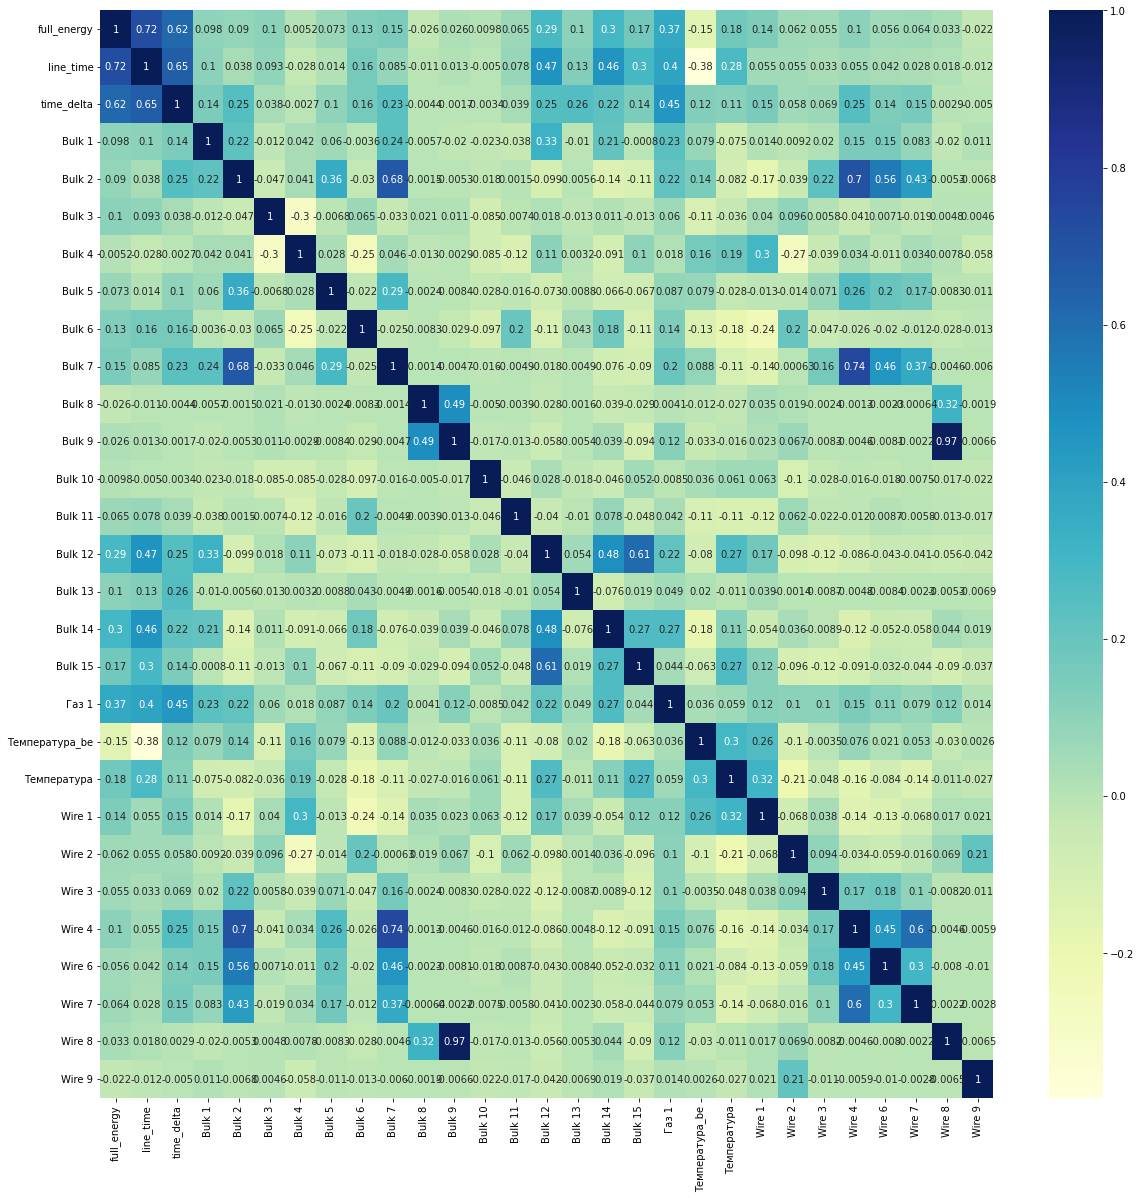

In [44]:
fig, ax = plt.subplots(figsize=(20,20))       
sb.heatmap(table.corr(), cmap="YlGnBu", annot=True,ax=ax)
plt.show()

Удалим Bulk 9, который имеет автокорелляцию с Wire 8

In [45]:
table.drop('Bulk 9',inplace=True,axis=1)

In [46]:
table.columns

Index(['full_energy', 'line_time', 'time_delta', 'Bulk 1', 'Bulk 2', 'Bulk 3',
       'Bulk 4', 'Bulk 5', 'Bulk 6', 'Bulk 7', 'Bulk 8', 'Bulk 10', 'Bulk 11',
       'Bulk 12', 'Bulk 13', 'Bulk 14', 'Bulk 15', 'Газ 1', 'Температура_be',
       'Температура', 'Wire 1', 'Wire 2', 'Wire 3', 'Wire 4', 'Wire 6',
       'Wire 7', 'Wire 8', 'Wire 9'],
      dtype='object')

In [47]:
table.columns=['full_energy', 'line_time', 'time_delta', 'bulk_1', 'bulk_2', 'bulk_3',
       'bulk_4', 'bulk_5', 'bulk_6', 'bulk_7', 'bulk_8', 'bulk_10', 'bulk_11',
       'bulk_12', 'bulk_13', 'bulk_14', 'bulk_15', 'gas_1', 'temp_be',
       'temp_end', 'wire_1', 'wire_2', 'wire_3', 'wire_4', 'wire_5',
       'wire_7', 'wire_8', 'wire_9']

**Выводы:**
*Данные готовы к обучению*

- данные очищены
- ДатаСет объединён
- изучена корелляционная матрица, устранена автоколерряция

## Часть 6: Машинное обучение

Разделим данные на параметры и целевые.

In [48]:
target=table['temp_end']
features=table.drop('temp_end',axis=1)

In [49]:
features.head()

,full_energy,line_time,time_delta,bulk_1,bulk_2,bulk_3,bulk_4,bulk_5,bulk_6,bulk_7,...,gas_1,temp_be,wire_1,wire_2,wire_3,wire_4,wire_5,wire_7,wire_8,wire_9
key,,,,,,,,,,,,,,,,,,,,,
1,3.718736,1098.0,1583.0,0.0,0.0,0.0,43.0,0.0,0.0,0.0,...,29.749986,1571.0,60.059998,0.00000,0.0,0.0,0.0,0.0,0.0,0.0
2,2.588349,811.0,1144.0,0.0,0.0,0.0,73.0,0.0,0.0,0.0,...,12.555561,1581.0,96.052315,0.00000,0.0,0.0,0.0,0.0,0.0,0.0
3,5.019223,655.0,1525.0,0.0,0.0,0.0,34.0,0.0,0.0,0.0,...,28.554793,1596.0,91.160157,0.00000,0.0,0.0,0.0,0.0,0.0,0.0
4,3.400038,741.0,1093.0,0.0,0.0,0.0,81.0,0.0,0.0,0.0,...,18.841219,1601.0,89.063515,0.00000,0.0,0.0,0.0,0.0,0.0,0.0
5,2.816980,869.0,1362.0,0.0,0.0,0.0,78.0,0.0,0.0,0.0,...,5.413692,1576.0,89.238236,9.11456,0.0,0.0,0.0,0.0,0.0,0.0


In [50]:
target.head()

key
1    1613.0
2    1602.0
3    1599.0
4    1625.0
5    1602.0
Name: temp_end, dtype: float64

Теперь разделим на **тренировочные и тестовые**

In [51]:
train_features,test_features,train_target,test_target=train_test_split(features,target,random_state=RANDOM_STATE,test_size=.25)

In [52]:
for i in (train_features,test_features,train_target,test_target):
    print(i.shape)
#рассмотрим размеры

(1746, 27)
(583, 27)
(1746,)
(583,)


### Линейная регрессия

In [53]:
model=LinearRegression()
mae = make_scorer(mean_absolute_error, greater_is_better=False)
res_linreg=abs(cross_val_score(model,train_features,train_target,scoring=mae,cv=CV).mean())
print('MAE with LinReg:',res_linreg)

MAE with LinReg: 6.18148807206426


### LightGBM Regressor

In [54]:
%%time


params = { 'max_depth': range(2, 3),           
           'n_estimators': range(100, 150),        
           'learning_rate': [0.2],            
           'boosting_type': ['gbdt'],     
           'random_state': [RANDOM_STATE]}


model_lgbm, lgbm_score = model_initialize(LGBMRegressor(verbose=-1), params)




MAE of LGBMRegressor = 5.962603142659567
Wall time: 6.44 s


### CatBoost Regressor

In [55]:
%%time

params = { 'depth':  range(6, 7),             
           'n_estimators': range(31, 32),     
           'learning_rate': [0.34],                        
           'silent': [True],
           'random_seed': [RANDOM_STATE]
        }


model_cat, cat_score = model_initialize(CatBoostRegressor(), params)   


MAE of CatBoostRegressor = 6.066427111304719
Wall time: 860 ms


In [56]:
#results=pd.DataFrame()
#results.index=
results = pd.DataFrame({'model':[LinearRegression().__class__.__name__,LGBMRegressor().__class__.__name__,\
                                 CatBoostRegressor().__class__.__name__], 'МАЕ': [res_linreg,lgbm_score,cat_score]})

#for i in 


results

,model,МАЕ
0,LinearRegression,6.181488
1,LGBMRegressor,5.962603
2,CatBoostRegressor,6.066427


Итак, победил **LightGBM Regressor**

**Выводы:**
- найдена наиболее точная модель LGBM (лучше, чем LinReg и CatBoost)
- перебраны 5 гиперпараметров для моделей (кроме LinReg)
- MAE в кросс-валидации в допустимых пределах
- в обучении использованы 27 параметров


## Часть 7: Тестирование и рассмотрение важности признаков

In [57]:
print('MAE of LGBM on test data:',mean_absolute_error(model_lgbm.predict(test_features),test_target))

MAE of LGBM on test data: 6.012311570469401


Задача **выполнена**, MAE < 6.8

Проверим модель на адекватность

In [58]:
check = DummyRegressor(strategy='mean').fit(train_features, train_target)
check_mae = mean_absolute_error(test_target, check.predict(test_features))

print('\nMAE dummy (mean) =', check_mae) 


MAE dummy (mean) = 7.915954919747958


Модель лучше, чем константный регрессор, предсказывающий среднее значение

Рассмотрим важность признаков

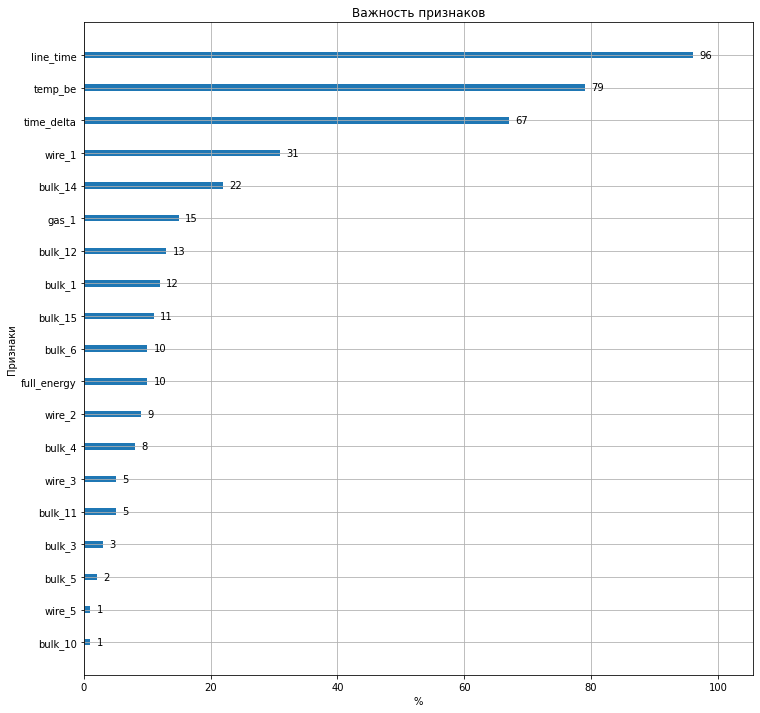

In [59]:
#fig, ax = plt.subplots(figsize=(20,20))       

plot_importance(model_lgbm,figsize=(12,12),xlabel='%',ylabel='Признаки',title="Важность признаков")
plt.show()

Итак, топ-3 важных параметров:

1) Время на процессы обработки (96)

2) Изначальная температура (79)

3) Общее время обработку (67)

**Выводы:**
- найдена наиболее точная модель LGBM (лучше, чем LinReg и CatBoost)
- MAE в допустимых пределах
- наиболее важный параметр - время на процессы обработки ковша
- модель адекватна

# Отчет



Согласно плану, предполагалось выполнить следующие действия:

    1. Предобработка исходных данных. -- ✅ данные изучены, рассмотрены выбросы и распределения

    2. Подготовка данных к обучению. -- ✅ были отобраны и созданы важные числовые параметры, а также отброшены выбросы и пропуски

    3. Подбор релевантной модели и её обучение. -- ✅ по результатам выиграла модель LGBM Regressor

    4. Тестирование модели. -- ✅ модель протестирована. Результат - MAE 6.012, что *меньше* порога в 6.8
    
В процессе создания модели возникли трудности с:
    
    - обработкой данных и исключением действительно маловажных значений
    
    - "сшиванием" нескольких таблиц в одну
    
    в остальном трудностей не возникало
    
Ключевые шаги в решении задачи:

    - изучить бизнес-задачу и понять, как решить её с помощью DS
    
    - определить важные параметры для модели, поработать со столбцами datetime
    
    - подобрать лучшую модель, используя различные гиперпараметры
    
    - изучить важность факторов, определяющих целевую переменную
    
Итоговая модель -- LGBM Regressor (MAE = 6.012 test выборка)

Признаки, использованные при обучении модели:

    'full_energy' - полная энергия, затраченная на весь процесс обработки

    'line_time' - суммарное время всех операций обработки

    'time_delta' - общее время обработки (время конца - время начала)

    'bulk_X' (14 параметров с разными X) - данные об обработки bulk

    'gas_1' - данные об обработки gas

    'temp_be'- температура ковша до обработки

    'wire_X' (8 параметров с разными X) - данные об обработки wire

Гиперпараметры модели (переменная model_lgbm):

- learning_rate=0.2
- max_depth=2
- n_estimators=144
- random_state=170723

Для улучшения модели рекомендуется:

- уточнить данные по пропущенным значениям
- увеличить объем входных данных
- рассмотреть иные модели (напр., RandomForestRegressor, XGBoost)
- учесть иные данные, влияющие на температуру (напр., температура окружающей среды, влажность)